In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import pywt
import gc
import IPython
import matplotlib.pyplot as plt

# Setting up CUDA device and CIFAR10 dataset
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CUDA = torch.cuda.is_available()
torch.cuda.set_device(DEVICE)
H_DIM = 32
W_DIM = 32
LOG_INTERVAL = 10
BATCH_SIZE = 64
train_losses = []

In [2]:
# Setting up WT layers
w=pywt.Wavelet('bior2.2')


dec_hi = torch.Tensor(w.dec_hi[::-1]).cuda() 
dec_lo = torch.Tensor(w.dec_lo[::-1]).cuda()
rec_hi = torch.Tensor(w.rec_hi).cuda()
rec_lo = torch.Tensor(w.rec_lo).cuda()
dec_hi_cpu = torch.Tensor(w.dec_hi[::-1]).clone().cpu()
dec_lo_cpu = torch.Tensor(w.dec_lo[::-1]).clone().cpu()
rec_hi_cpu = torch.Tensor(w.rec_hi).clone().cpu()
rec_lo_cpu = torch.Tensor(w.rec_lo).clone().cpu()


filters = torch.stack([dec_lo_cpu.unsqueeze(0)*dec_lo_cpu.unsqueeze(1),
                       dec_lo_cpu.unsqueeze(0)*dec_hi_cpu.unsqueeze(1),
                       dec_hi_cpu.unsqueeze(0)*dec_lo_cpu.unsqueeze(1),
                       dec_hi_cpu.unsqueeze(0)*dec_hi_cpu.unsqueeze(1)], dim=0)

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)


def wt(vimg, levels=1):
    h = vimg.size(2)
    w = vimg.size(3)
#     print(vimg.shape)
    padded = torch.nn.functional.pad(vimg,(2,2,2,2))
    res = torch.nn.functional.conv2d(padded, Variable(filters[:,None]),stride=2)
    if levels>1:
        res[:,:1] = wt(res[:,:1],levels-1)
        res[:,:1,32:,:] = res[:,:1,32:,:]*1.
        res[:,:1,:,32:] = res[:,:1,:,32:]*1.
        res[:,1:] = res[:,1:]*1.
    res = res.view(-1,2,h//2,w//2).transpose(1,2).contiguous().view(-1,1,h,w)
    return res

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

class CIFAR10WT(torchvision.datasets.CIFAR10):
    def __init__(self, wt=False, **kwargs):
        super().__init__(**kwargs)
        self.wt = wt
    
    def _load_meta(self):
        super()._load_meta()
    
    def __len__(self):
        return super().__len__()

    def _check_integrity(self):
        return super()._check_integrity()

    def download(self):
        super().download()

    def extra_repr(self):
        return super().extra_repr()
    
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        
        if self.wt:
            img = wt(img.unsqueeze(1)).squeeze()
        
        return img, target


train_set = CIFAR10WT(wt=True, root='./cifar10_data', train=True,
                                        download=True, transform=transform)

train_size = int(len(train_set)*0.8)
train_set, val_set = torch.utils.data.random_split(train_set, (train_size, len(train_set)-train_size))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = CIFAR10WT(wt=True, root='./cifar10_data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Shape of images in dataset
print('Image shape: {}'.format(train_set[0][0].shape))

Files already downloaded and verified
Files already downloaded and verified
Image shape: torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


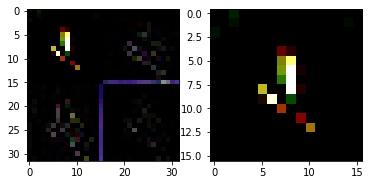

In [5]:
sample = train_set[300][0]
print(sample.shape)
sample_x1 = sample[:,:H_DIM//2,:W_DIM//2]
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample.numpy().transpose((1,2,0)))
ax[1].imshow(sample_x1.numpy().transpose((1,2,0)))


In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class WTClassifier(nn.Module):
    def __init__(self):
        super(WTClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),  # N * 32 * 14 * 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1), # N * 64 * 12 * 12
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2), # N * 32 * 6 * 6
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1), # N * 128 * 4 * 4
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1), # N * 256 * 2 * 2
            nn.BatchNorm2d(256),
            nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(2,2), stride=1), # N * 128 * 8 * 8
#             nn.Conv2d(256, 512, kernel_size=3, stride=1), # N * 512 * 4 * 4
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1), # N * 1024 * 2 * 2
#             nn.ReLU(),
            Flatten()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(9, 32, kernel_size=3, stride=1), # N * 32 * 14 * 14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1), # N * 64 * 12 * 12
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2), # N * 32 * 6 * 6
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1), # N * 128 * 4 * 4
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1), # N * 256 * 2 * 2
            nn.BatchNorm2d(256),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(256 * 2 * 2 * 2, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x1 = x[:,:,:H_DIM//2,:W_DIM//2]
        x2 = x[:,:,:H_DIM//2,W_DIM//2:]
        x3 = x[:,:,H_DIM//2:,:W_DIM//2]
        x4 = x[:,:,H_DIM//2:,W_DIM//2:]
        
        x_rest = torch.cat((x2, x3, x4), 1)
 
        x1 = self.conv1(x1)
        x_rest = self.conv2(x_rest)
        x = torch.cat((x1, x_rest), 1)
        
#         x = self.conv1(x1)
#         print(x.shape)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
def train(epoch, model, criterion, optimizer, train_loader):
    # Toggle model to train mode
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        
        inputs, labels = data

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        train_loss += loss.item()
        train_losses.append(loss.item())
        optimizer.step()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(labels),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss / len(labels)))
            
#             n = min(data.size(0), 8)
           

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
def eval(model, criterion, val_loader):
    # Toggle model to train mode
    model.eval()
    val_loss = 0
    total = 0
    correct = 0
    
    for batch_idx, data in enumerate(val_loader):
        inputs, labels = data

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#         if batch_idx % LOG_INTERVAL == 0:
#             print('Validation: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(batch_idx * len(labels),
#                                                                            len(val_loader.dataset),
#                                                                            100. * batch_idx / len(val_loader),
#                                                                            loss / len(labels)))
           
    print('====> Evaluation Accuracy: {:.4f}'.format(correct / total))
    return (correct / total)

In [8]:
gc.collect()
EPOCHS = 30
train_losses.clear()
train_accs = []
val_accs = []

model = WTClassifier()
if CUDA: 
    print('CUDA = TRUE')
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    train(epoch, model, criterion, optimizer, train_loader)  
    
    # Evaluate on train and validation sets and save into lists
    train_acc = eval(model, criterion, train_loader)
    val_acc = eval(model, criterion, val_loader)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    

CUDA = TRUE
Train Epoch: 1 [0/40000 (0%)]	Loss: 0.035939
Train Epoch: 1 [640/40000 (2%)]	Loss: 0.032063
Train Epoch: 1 [1280/40000 (3%)]	Loss: 0.025962
Train Epoch: 1 [1920/40000 (5%)]	Loss: 0.028002
Train Epoch: 1 [2560/40000 (6%)]	Loss: 0.026641
Train Epoch: 1 [3200/40000 (8%)]	Loss: 0.027573
Train Epoch: 1 [3840/40000 (10%)]	Loss: 0.023173
Train Epoch: 1 [4480/40000 (11%)]	Loss: 0.025066
Train Epoch: 1 [5120/40000 (13%)]	Loss: 0.025074
Train Epoch: 1 [5760/40000 (14%)]	Loss: 0.023270
Train Epoch: 1 [6400/40000 (16%)]	Loss: 0.024588
Train Epoch: 1 [7040/40000 (18%)]	Loss: 0.023680
Train Epoch: 1 [7680/40000 (19%)]	Loss: 0.023367
Train Epoch: 1 [8320/40000 (21%)]	Loss: 0.024406
Train Epoch: 1 [8960/40000 (22%)]	Loss: 0.017996
Train Epoch: 1 [9600/40000 (24%)]	Loss: 0.018576
Train Epoch: 1 [10240/40000 (26%)]	Loss: 0.021062
Train Epoch: 1 [10880/40000 (27%)]	Loss: 0.021120
Train Epoch: 1 [11520/40000 (29%)]	Loss: 0.016527
Train Epoch: 1 [12160/40000 (30%)]	Loss: 0.019652
Train Epoch: 1

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 40000 train images: %d %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

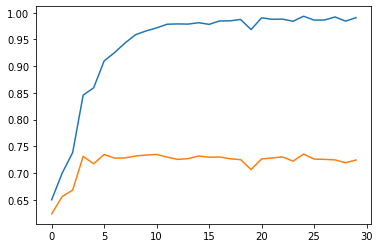

In [9]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.show()

In [ ]:
model